<a href="https://colab.research.google.com/github/IshaghCheikh/ProjetStat/blob/main/CodePython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas geopandas matplotlib pyproj shapely fiona contextily plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 51.8 MB/s eta 0:00:00


In [2]:

# Imports
import os
import subprocess
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Optional (for chord-like visualizations later, if you want)
import plotly.express as px


In [4]:

# -------------------------------
# Clone repository and move into it
# -------------------------------
if not os.path.exists("bayesFlow"):
    subprocess.run(["git", "clone", "https://github.com/ngwelch/bayesFlow.git"], check=True)

os.chdir("bayesFlow")

In [6]:

# -------------------------------
# Load tabular data
# -------------------------------
regions = pd.read_csv("local/data/200isoRegionCodes.csv")
f1 = pd.read_csv("local/data/abelCohen2019flowsv6.csv")
f2 = pd.read_csv("local/data/abelCohen2019flowsv6_flowdt.csv")
f3 = pd.read_csv("local/data/azoseRaftery2019flows.csv")


In [7]:

# Peek
print(f2.head())
print(f3.head())


   year0 orig dest  flow
0   1990  COM  BDI     0
1   1990  DJI  BDI     0
2   1990  ERI  BDI    90
3   1990  ETH  BDI     2
4   1990  KEN  BDI    87
   origin  destination origIso destIso  year  migrantCount
0     533            4     ABW     AFG  1990             0
1     533            4     ABW     AFG  1995             0
2     533            4     ABW     AFG  2000             0
3     533            4     ABW     AFG  2005             0
4     533            4     ABW     AFG  2010             0


In [20]:
# --- OPTION B: Download world-administrative-boundaries + build joins ---

import os, io, zipfile
import pandas as pd
import geopandas as gpd

# If requests isn't available, do:  pip install requests
import requests

# 1) Download the shapefile ZIP from Opendatasoft (Shapefile export)
os.makedirs("data/world_admin", exist_ok=True)
zip_url = ("https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/"
           "download/?format=shp&timezone=UTC&lang=en&use_labels_for_header=false")

print("Downloading shapefile…")
r = requests.get(zip_url, timeout=120)
r.raise_for_status()
with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
    zf.extractall("data/world_admin")

# 2) Read the .shp file we just extracted (name may vary a little)
shp_candidates = [p for p in os.listdir("data/world_admin") if p.lower().endswith(".shp")]
if not shp_candidates:
    raise FileNotFoundError("No .shp found in data/world_admin after download.")
shp_path = os.path.join("data/world_admin", shp_candidates[0])

wrld = gpd.read_file(shp_path)
wrld.columns = [c.strip() for c in wrld.columns]  # tidy names

# 3) Harmonize to expected names:
# The Opendatasoft dataset generally contains columns like: 'iso3', 'name', 'continent' (case can vary).
# We'll try a few common variants to map onto 'iso3', 'name', 'continent'.
def first_present(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols_lower = {c.lower(): c for c in wrld.columns}
iso_col = first_present(cols_lower, ["iso3", "iso_3", "iso3_code"])
name_col = first_present(cols_lower, ["name", "country", "country_name"])
cont_col = first_present(cols_lower, ["continent"])

missing = []
if iso_col is None: missing.append("iso3")
if name_col is None: missing.append("name")
if cont_col is None: missing.append("continent")

if missing:
    raise KeyError(
        f"Could not find required columns in the shapefile: {missing}. "
        f"Available columns: {list(wrld.columns)}"
    )

wrld = wrld.rename(columns={
    cols_lower[iso_col]: "iso3",
    cols_lower[name_col]: "name",
    cols_lower[cont_col]: "continent"
})

# Some rows can have missing/invalid ISO3 codes; drop those
wrld = wrld[wrld["iso3"].notna()].copy()
wrld["iso3"] = wrld["iso3"].astype(str)

# 4) Build origin/destination lookup tables with geometry columns
df_origin = wrld.rename(columns={
    "iso3": "orig",
    "continent": "continent_origin",
    "geometry": "geometry_origin",
    "name": "name_origin"
})
df_dest = wrld.rename(columns={
    "iso3": "dest",
    "continent": "continent_dest",
    "geometry": "geometry_dest",
    "name": "name_dest"
})

# 5) Join flows (f2) with origin & destination attributes
#    (Assumes f2 has columns: year0, orig, dest, flow)
merge_left = ["orig","continent_origin","geometry_origin","name_origin"]
merge_right = ["dest","continent_dest","geometry_dest","name_dest"]

df_joined = (
    f2.merge(df_origin[merge_left], on="orig", how="left")
      .merge(df_dest[merge_right], on="dest", how="left")
)

# Keep a consistent column order
df = df_joined[[
    "year0","orig","dest","name_origin","name_dest","flow",
    "continent_origin","continent_dest","geometry_origin","geometry_dest"
]].copy()

# 6) Aggregate to inflows / outflows and convert to GeoDataFrames
df_outflows = (
    df.groupby(["year0","orig","continent_origin"], dropna=False, as_index=False)
      .agg(total_outflow=("flow","sum"))
)
origin_geom = (
    df.groupby(["year0","orig","continent_origin"], dropna=False)["geometry_origin"]
      .first().reset_index(name="geometry")
)
gdf_outflows = gpd.GeoDataFrame(
    df_outflows.merge(origin_geom, on=["year0","orig","continent_origin"], how="left"),
    geometry="geometry",
    crs=wrld.crs
)

df_inflows = (
    df.groupby(["year0","dest","continent_dest"], dropna=False, as_index=False)
      .agg(total_inflow=("flow","sum"))
)
dest_geom = (
    df.groupby(["year0","dest","continent_dest"], dropna=False)["geometry_dest"]
      .first().reset_index(name="geometry")
)
gdf_inflows = gpd.GeoDataFrame(
    df_inflows.merge(dest_geom, on=["year0","dest","continent_dest"], how="left"),
    geometry="geometry",
    crs=wrld.crs
)

# 7) Quick sanity check on unmatched ISO3s (optional)
missing_orig = df[df["continent_origin"].isna()]["orig"].drop_duplicates().tolist()
missing_dest = df[df["continent_dest"].isna()]["dest"].drop_duplicates().tolist()
print("Unmatched origin ISO3:", missing_orig)
print("Unmatched dest ISO3:", missing_dest)
print("Shapefile loaded from:", shp_path)


Unmatched origin ISO3: ['CLI', 'CUW']
Unmatched dest ISO3: ['CLI', 'CUW']
Shapefile loaded from: data/world_admin/world-administrative-boundaries.shp


   year0 orig continent_origin  total_outflow  \
0   1990  USA         Americas        3881240   
1   1990  IND             Asia        3118061   
2   1990  PAK             Asia        2779579   
3   1995  USA         Americas        3393408   
4   1995  MEX         Americas        3313472   

                                            geometry  
0  MULTIPOLYGON (((-155.00558 19.32888, -155.1453...  
1  MULTIPOLYGON (((93.89941 6.80708, 93.82707 6.7...  
2  POLYGON ((75.32261 32.32444, 75.32654 32.30044...  
3  MULTIPOLYGON (((-155.00558 19.32888, -155.1453...  
4  MULTIPOLYGON (((-91.82862 18.63916, -91.83446 ...  
   year0 dest continent_dest  total_inflow  \
0   1990  USA       Americas       8315645   
1   1990  RUS         Europe       5103163   
2   1990  DEU         Europe       3444277   
3   1995  USA       Americas      12194345   
4   1995  RUS         Europe       4905841   

                                            geometry  
0  MULTIPOLYGON (((-155.00558 19.32888, -15

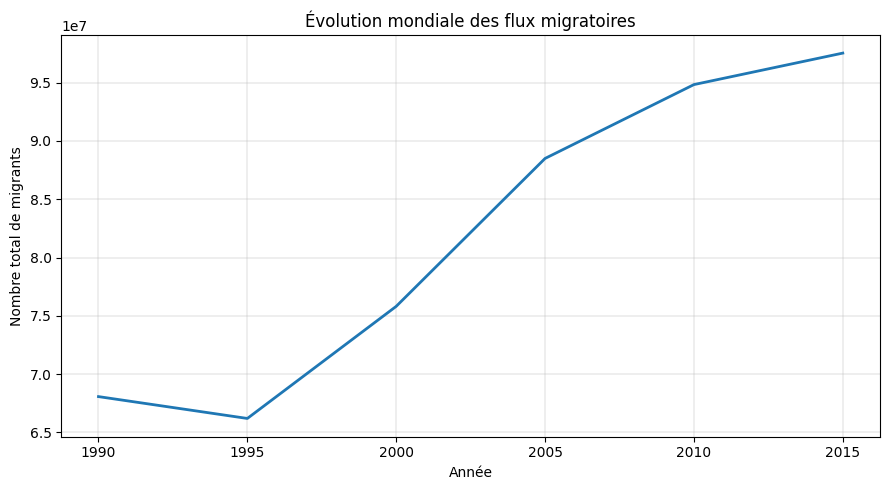

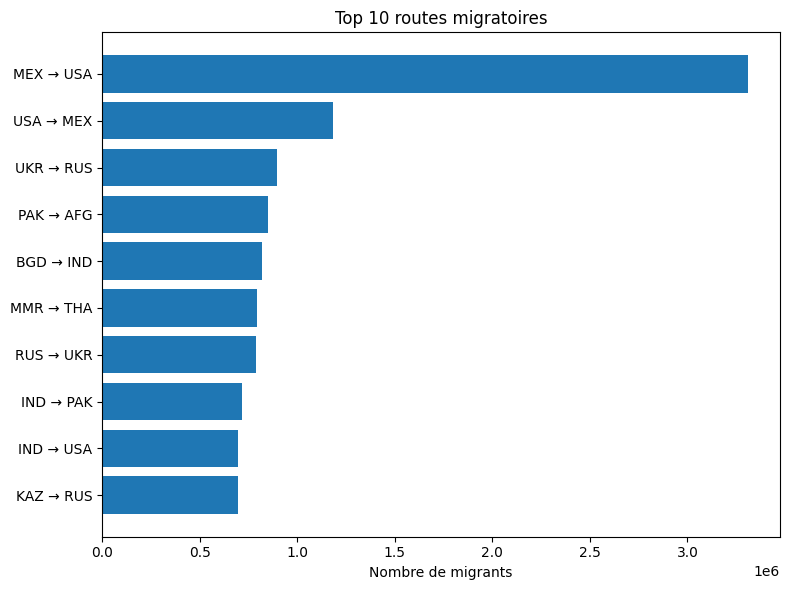

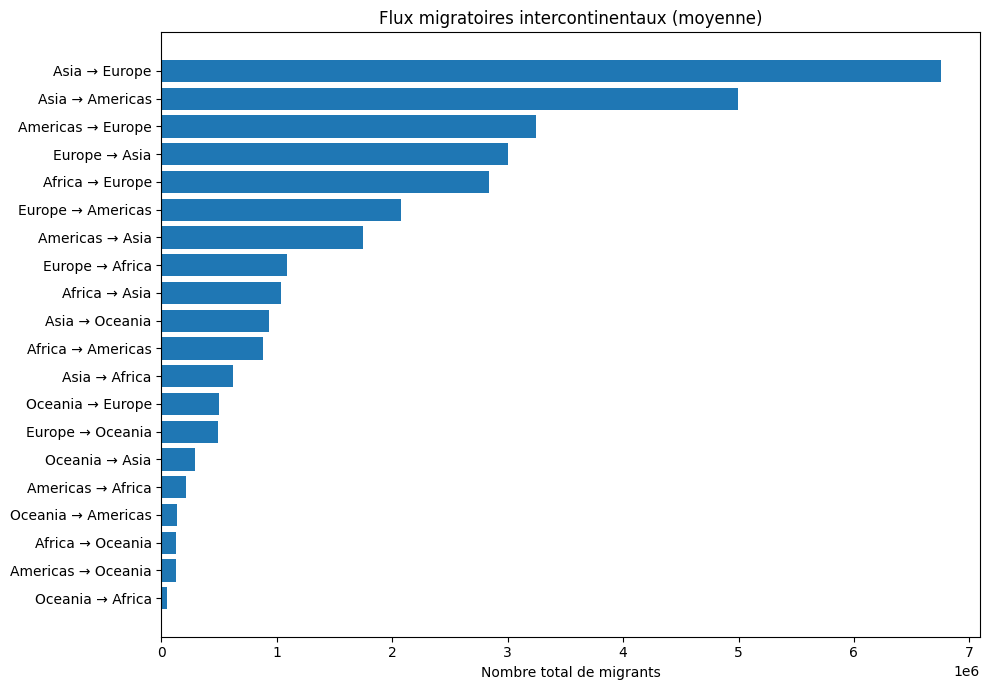

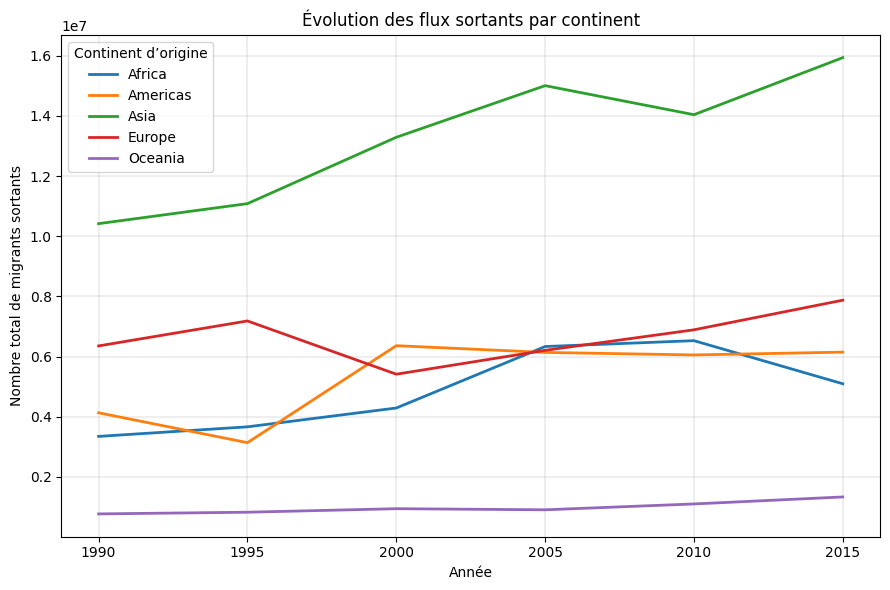

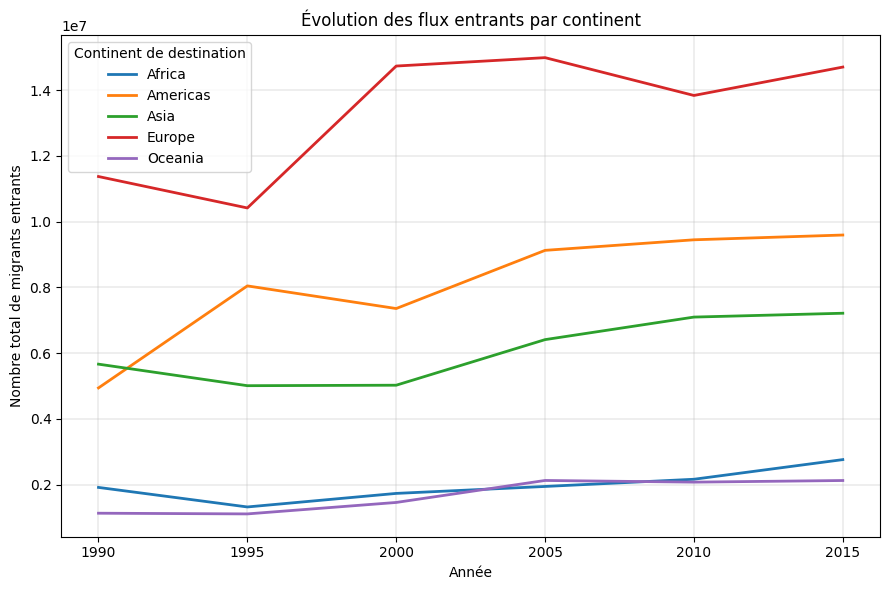

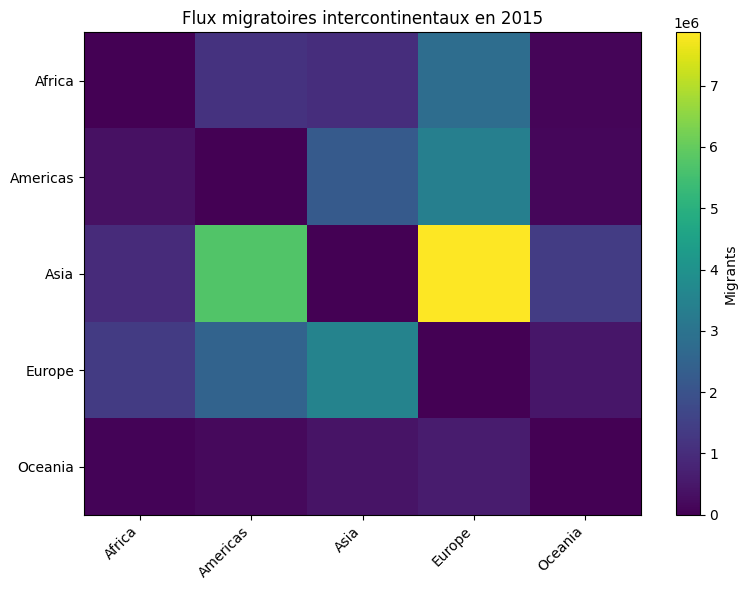

In [21]:
# -------------------------------
# Descriptive analysis
# -------------------------------

# Top emitters per year (top 3)
top_outflow_countries = (
    gdf_outflows
    .sort_values(["year0", "total_outflow"], ascending=[True, False])
    .groupby("year0")
    .head(3)
    .reset_index(drop=True)
)
print(top_outflow_countries.head())

# Top receivers per year (top 3)
top_inflow_countries = (
    gdf_inflows
    .sort_values(["year0", "total_inflow"], ascending=[True, False])
    .groupby("year0")
    .head(3)
    .reset_index(drop=True)
)
print(top_inflow_countries.head())

# Global total by year (sum of outflows)
df_global_trends = (
    gdf_outflows.groupby("year0", as_index=False)
    .agg(total_inflow=("total_outflow", "sum"))
)

# Evolution plot
plt.figure(figsize=(9, 5))
plt.plot(df_global_trends["year0"], df_global_trends["total_inflow"], linewidth=2)
plt.title("Évolution mondiale des flux migratoires")
plt.xlabel("Année")
plt.ylabel("Nombre total de migrants")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# Total cumulative by country pair (filter year == 2000)
df_routes = (
    df.loc[df["year0"] == 2000]
      .groupby(["orig", "dest"], as_index=False)
      .agg(total_flow=("flow", "sum"))
      .sort_values("total_flow", ascending=False)
)

top_routes = df_routes.head(10).copy()
# Horizontal bar chart
plt.figure(figsize=(8, 6))
labels = (top_routes["orig"] + " → " + top_routes["dest"]).tolist()
plt.barh(range(len(top_routes)), top_routes["total_flow"])
plt.yticks(range(len(top_routes)), labels)
plt.gca().invert_yaxis()
plt.title("Top 10 routes migratoires")
plt.xlabel("Nombre de migrants")
plt.tight_layout()
plt.show()

# -------------------------------
# Inter-continental analysis
# -------------------------------
df_continent_flows = (
    df.loc[df["continent_origin"] != df["continent_dest"]]
      .groupby(["continent_origin", "continent_dest", "year0"], as_index=False)
      .agg(total_flow=("flow", "sum"))
      .dropna()
)

# Top intercontinental flows (average over years) – barplot
avg_continent_flows = (
    df_continent_flows.groupby(["continent_origin", "continent_dest"], as_index=False)
    .agg(total_flow=("total_flow", "mean"))
    .sort_values("total_flow", ascending=False)
)

plt.figure(figsize=(10, 7))
labels = (avg_continent_flows["continent_origin"] + " → " + avg_continent_flows["continent_dest"]).tolist()
plt.barh(range(len(avg_continent_flows)), avg_continent_flows["total_flow"])
plt.yticks(range(len(avg_continent_flows)), labels)
plt.gca().invert_yaxis()
plt.title("Flux migratoires intercontinentaux (moyenne)")
plt.xlabel("Nombre total de migrants")
plt.tight_layout()
plt.show()

# Outflows by continent over time
df_out_by_continent = (
    df_continent_flows.groupby(["year0", "continent_origin"], as_index=False)
    .agg(total_outflow=("total_flow", "sum"))
)

plt.figure(figsize=(9, 6))
for cont, sub in df_out_by_continent.groupby("continent_origin"):
    plt.plot(sub["year0"], sub["total_outflow"], linewidth=2, label=cont)
plt.title("Évolution des flux sortants par continent")
plt.xlabel("Année")
plt.ylabel("Nombre total de migrants sortants")
plt.legend(title="Continent d’origine")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# Inflows by continent over time
df_in_by_continent = (
    df_continent_flows.groupby(["year0", "continent_dest"], as_index=False)
    .agg(total_inflow=("total_flow", "sum"))
)

plt.figure(figsize=(9, 6))
for cont, sub in df_in_by_continent.groupby("continent_dest"):
    plt.plot(sub["year0"], sub["total_inflow"], linewidth=2, label=cont)
plt.title("Évolution des flux entrants par continent")
plt.xlabel("Année")
plt.ylabel("Nombre total de migrants entrants")
plt.legend(title="Continent de destination")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# Heatmap (continent-origin x continent-dest for a given year)
year_heat = 2015
mat_2015 = df_continent_flows.loc[df_continent_flows["year0"] == year_heat]
pivot = mat_2015.pivot(index="continent_origin", columns="continent_dest", values="total_flow").fillna(0)

plt.figure(figsize=(8, 6))
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title(f"Flux migratoires intercontinentaux en {year_heat}")
plt.colorbar(label="Migrants")
plt.tight_layout()
plt.show()

# (Optional) Chord diagram:
# Python doesn't have a base 'circlize' equivalent.
# You can build a chord chart with holoviews+bokeh:
#   pip install holoviews bokeh
#   from holoviews import opts, dim
#   import holoviews as hv; hv.extension('bokeh')
#   links = avg_continent_flows.rename(columns={"continent_origin":"source","continent_dest":"target","total_flow":"value"})
#   chord = hv.Chord((links[["source","target","value"]]))
#   chord.opts(opts.Chord(labels="index", edge_color=dim('source'), node_color=dim('index'), cmap="Category20", edge_cmap="Category20", width=800, height=800))
#   hv.save(chord, "chord_continents.html")


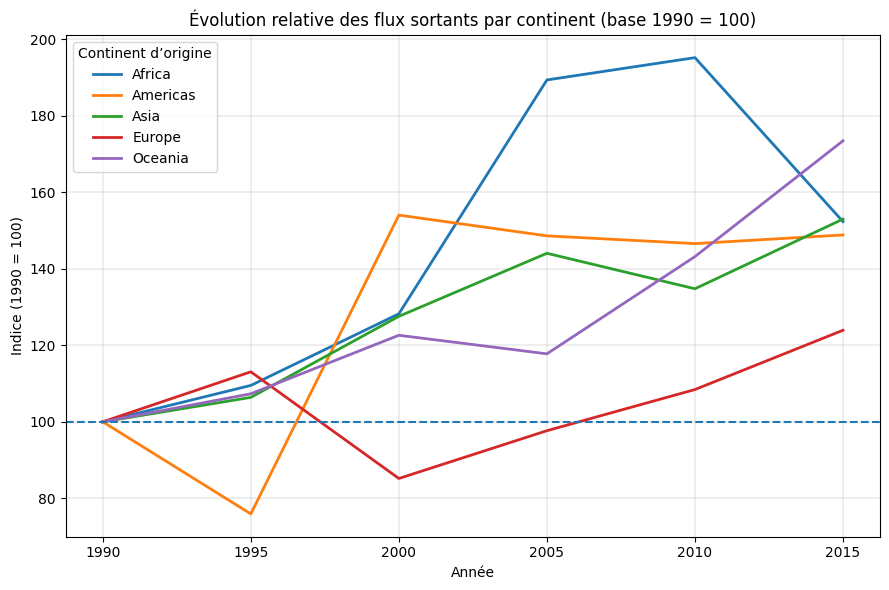

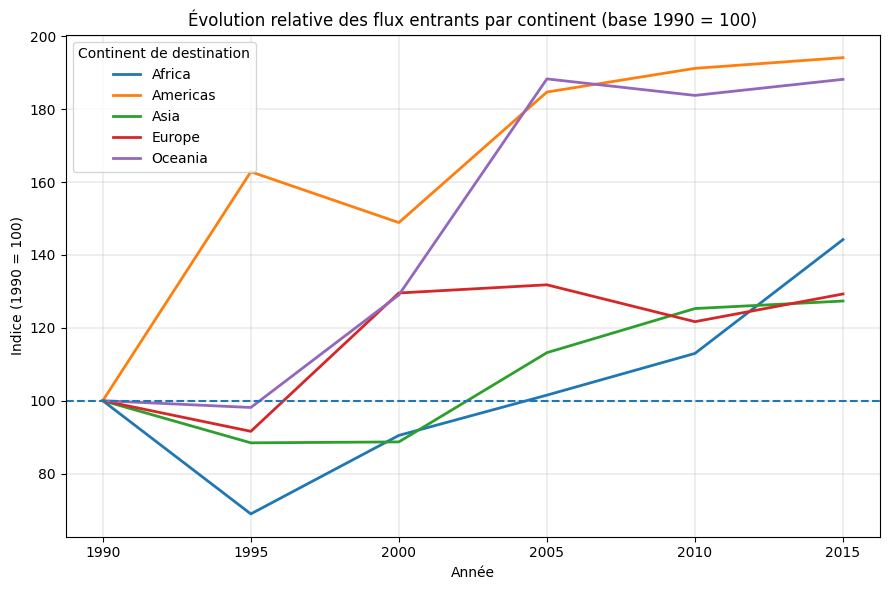

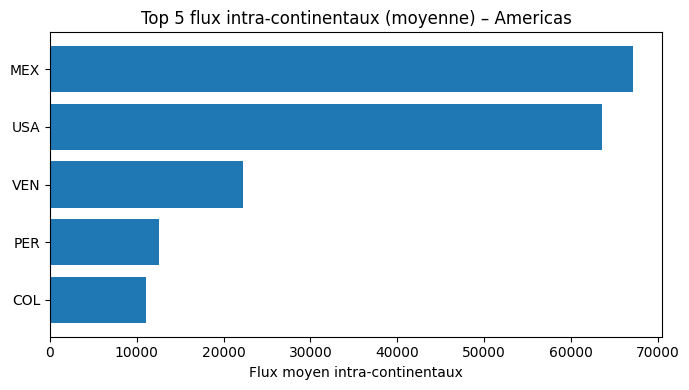

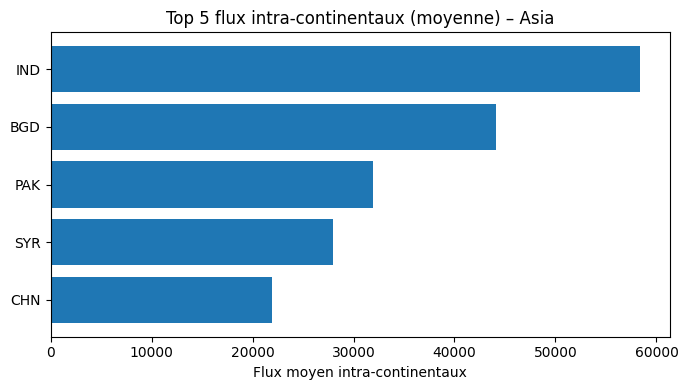

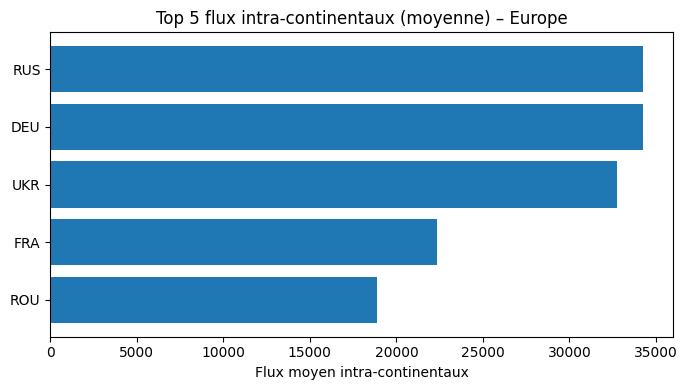

/tmp/ipython-input-2521228492.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sub["orig"].unique(), vert=True)


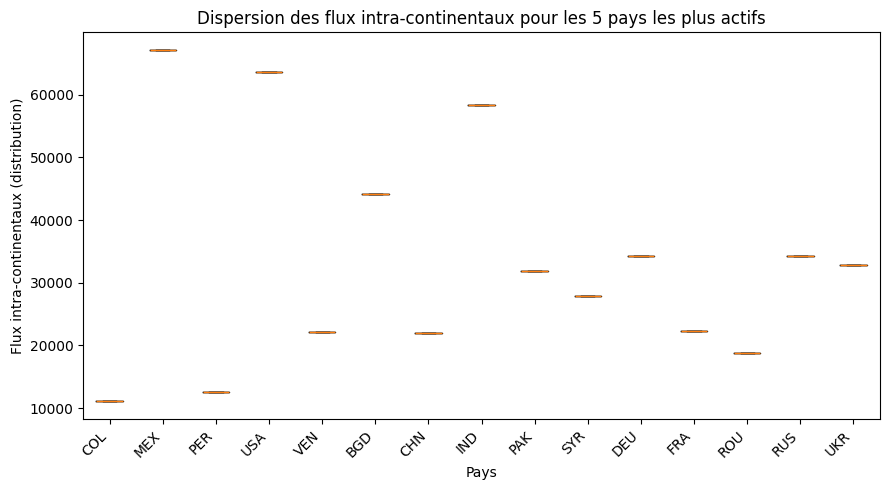

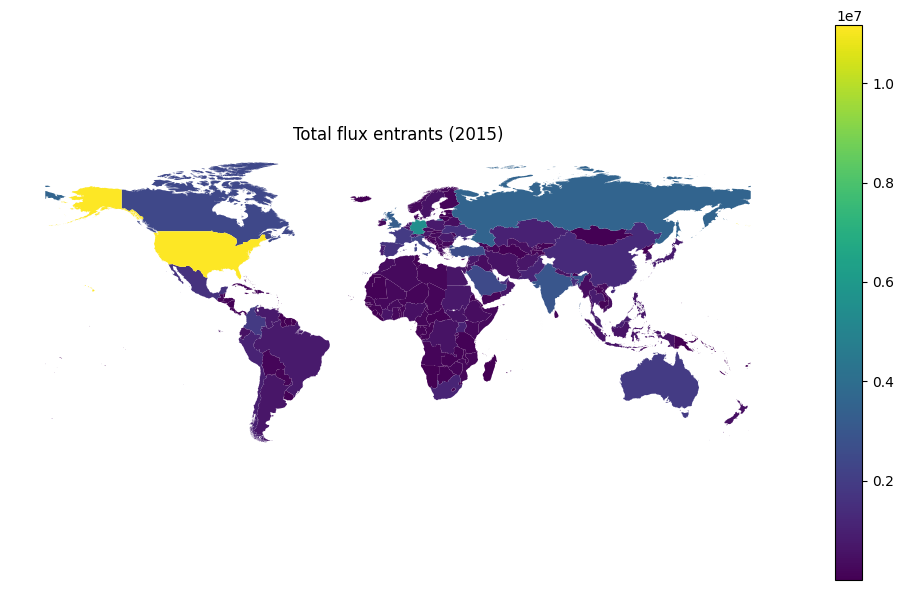

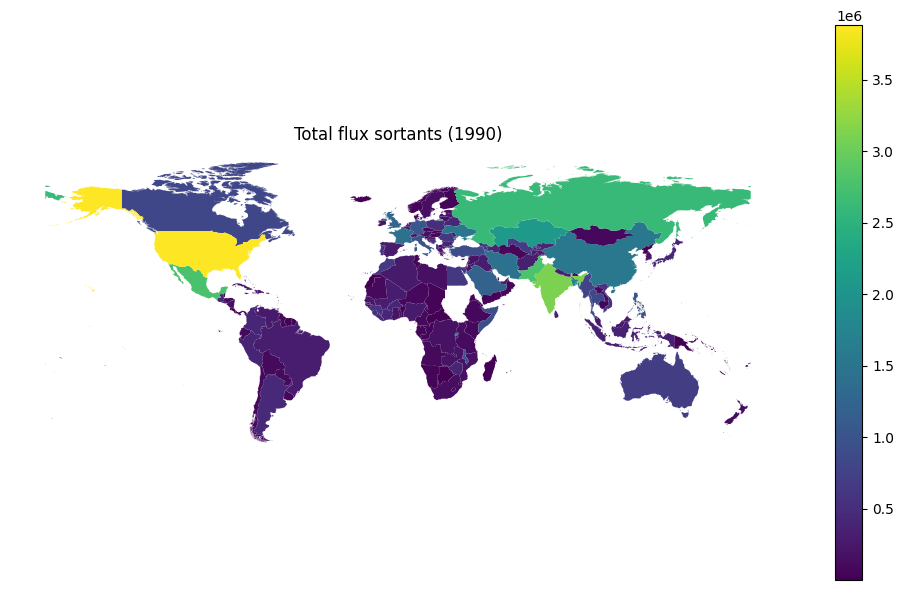

In [22]:
# -------------------------------
# Indexed evolution since 1990 (outflows)
# -------------------------------
def index_base_1990(df_, group_col, value_col):
    out = df_.copy()
    base = out.loc[out["year0"] == 1990, [group_col, value_col]].rename(columns={value_col: "base_1990"})
    out = out.merge(base, on=group_col, how="left")
    out["migration_index"] = (out[value_col] / out["base_1990"]) * 100
    return out

df_indexed_out = index_base_1990(df_out_by_continent, "continent_origin", "total_outflow")

plt.figure(figsize=(9, 6))
for cont, sub in df_indexed_out.groupby("continent_origin"):
    plt.plot(sub["year0"], sub["migration_index"], linewidth=2, label=cont)
plt.axhline(100, linestyle="--")
plt.title("Évolution relative des flux sortants par continent (base 1990 = 100)")
plt.xlabel("Année")
plt.ylabel("Indice (1990 = 100)")
plt.legend(title="Continent d’origine")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# Indexed evolution since 1990 (inflows)
df_indexed_in = index_base_1990(df_in_by_continent, "continent_dest", "total_inflow")

plt.figure(figsize=(9, 6))
for cont, sub in df_indexed_in.groupby("continent_dest"):
    plt.plot(sub["year0"], sub["migration_index"], linewidth=2, label=cont)
plt.axhline(100, linestyle="--")
plt.title("Évolution relative des flux entrants par continent (base 1990 = 100)")
plt.xlabel("Année")
plt.ylabel("Indice (1990 = 100)")
plt.legend(title="Continent de destination")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()

# -------------------------------
# Intra-continental analysis
# -------------------------------
df_intra = (
    df.loc[df["continent_origin"] == df["continent_dest"]]
      .loc[df["continent_origin"].isin(["Asia", "Europe", "Americas"])]
      .groupby(["continent_origin", "orig"], as_index=False)
      .agg(mean_flow=("flow", "mean"))
)

# Top 5 per continent
top5_intra = (
    df_intra.sort_values(["continent_origin", "mean_flow"], ascending=[True, False])
           .groupby("continent_origin")
           .head(5)
           .reset_index(drop=True)
)

# Facet-like plots (one per continent)
for cont, sub in top5_intra.groupby("continent_origin"):
    plt.figure(figsize=(7, 4))
    order = sub.sort_values("mean_flow", ascending=True)
    plt.barh(order["orig"], order["mean_flow"])
    plt.title(f"Top 5 flux intra-continentaux (moyenne) – {cont}")
    plt.xlabel("Flux moyen intra-continentaux")
    plt.tight_layout()
    plt.show()

# Boxplot dispersion for those top countries (distribution uses the same 'mean_flow' as in R boxplot example)
plt.figure(figsize=(9, 5))
sub = df_intra[df_intra["orig"].isin(top5_intra["orig"])]
# One box per country
data = [sub.loc[sub["orig"] == c, "mean_flow"].values for c in sub["orig"].unique()]
plt.boxplot(data, labels=sub["orig"].unique(), vert=True)
plt.title("Dispersion des flux intra-continentaux pour les 5 pays les plus actifs")
plt.xlabel("Pays")
plt.ylabel("Flux intra-continentaux (distribution)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# -------------------------------
# Choropleth maps (GeoPandas)
# -------------------------------

# Inflows map for 2015
g2015_in = gdf_inflows[gdf_inflows["year0"] == 2015]
ax = g2015_in.plot(column="total_inflow", figsize=(10, 6), legend=True)
ax.set_title("Total flux entrants (2015)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Outflows map for 1990
g1990_out = gdf_outflows[gdf_outflows["year0"] == 1990]
ax = g1990_out.plot(column="total_outflow", figsize=(10, 6), legend=True)
ax.set_title("Total flux sortants (1990)")
ax.set_axis_off()
plt.tight_layout()
plt.show()